# Primo Esempio di Notebook

In questo Notebook faremo degli esperimenti di stima di parametri con statistica inferenziale

I notebook permettono di utilizzare Latex

Bayes Theorem:

$P(p|dM) = \frac{P(d|pM)P(p|M)}{P(d|M)}$

## Download catalogue:
http://supernova.lbl.gov/Union/figures/SCPUnion2.1_mu_vs_z.txt

# Python Packages:

pip install emcee (or conda install emcee)

pip install pyGTC or pip install corner

# Gaussian Distribution:

$P(x) = \frac{1}{\sqrt{2\pi \sigma^2}} \mathrm{e}^{-\frac{(x - \mu )^2 }{2\sigma ^2}}$

Implies

$ln P(x)  = -0.5 ln (2 \pi \sigma^2) - 0.5 \big(\frac{ x - \mu  }{\sigma }\big) ^2$

So $\chi^2 \propto 2\ln L$



In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
SNdata = np.loadtxt("SCPUnion2.1_mu_vs_z.txt", usecols=(1,2,3,4))
print SNdata.shape

(580, 4)


In [3]:
z = SNdata[:,0] 
DM = SNdata[:,1]
DM_err = SNdata[:,2] 
P_low_mass = SNdata[:,3]  

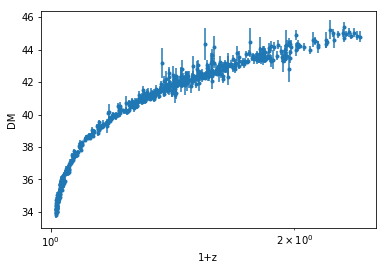

In [4]:
plt.errorbar(1+z,DM,DM_err,fmt='.')
plt.xlabel("1+z")
plt.ylabel("DM")
plt.xscale("log")

In [13]:
from astropy.cosmology import FlatLambdaCDM

In [14]:
z_array = np.linspace(0,1.5,100)
cosmo = FlatLambdaCDM(H0=70., Om0=0.3)
distmod = cosmo.distmod(z_array)

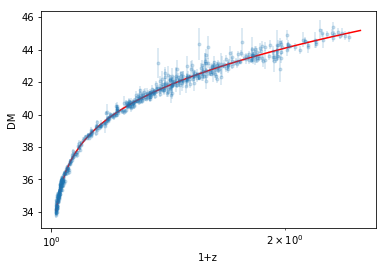

In [15]:
plt.errorbar(1+z,DM,DM_err,fmt='.',alpha=0.2)
plt.xlabel("1+z")
plt.ylabel("DM")
plt.xscale("log")
plt.plot(1+z_array,distmod,'r')

In [16]:
def distance_modulus(theta,z):
    H0, Om0 = theta
    cosmo = FlatLambdaCDM(H0=H0, Om0=Om0)
    distmod = np.array(cosmo.distmod(z))
    return distmod

In [17]:
def log_prior(theta):
    H0, Om0 = theta
    if 0 < H0 < 150 and 0.0 < Om0 < 2.0:
        return 0.0
    return -np.inf

In [18]:
def log_likelihood(theta, z, DM, DM_err):
    err = DM_err
    distmod = distance_modulus(theta,z)
    logl = np.sum(np.log(1./np.sqrt(2*np.pi*err*2)) -(DM-distmod)**2/(2.*err**2))
    return logl

In [19]:
def log_posterior(theta, z, DM, DM_err):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    logl = log_likelihood(theta, z, DM, DM_err)
    logpos = logl+lp
    return logpos, lp, logl


In [20]:
import emcee

pos = [70.,0.3] + 1e-2 * np.random.randn(16, 2)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(z, DM, DM_err))
sampler.run_mcmc(pos, 2000, progress=True);

100%|██████████| 2000/2000 [02:42<00:00, 12.32it/s]    | 2/2000 [00:00<02:46, 12.02it/s]


(2000, 16, 2)


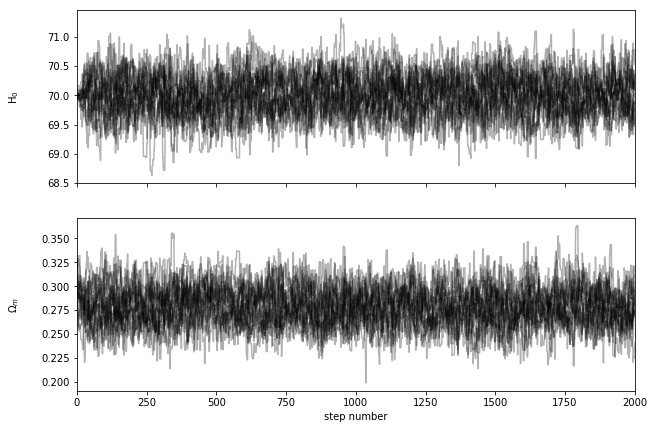

In [21]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
print samples.shape
labels = ["H$_0$", "$\Omega_{m}$"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [22]:
tau = sampler.get_autocorr_time()
print(tau)

[30.16730726 29.50572329]


In [23]:
flat_samples = sampler.get_chain(discard=100, flat=True)
flat_blob = sampler.get_blobs(flat=True,discard=100)

print(flat_samples.shape, flat_blob.shape)

Max_likelihood=np.argmax(flat_blob[:,1])
print flat_samples[Max_likelihood,:]

((30400, 2), (30400, 2))
[70.00131147  0.27747707]


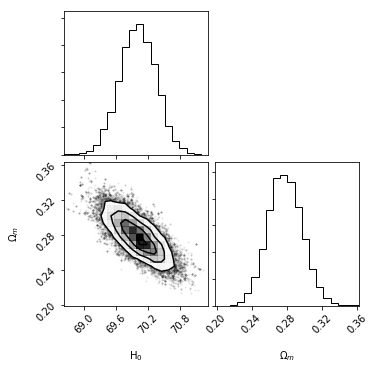

In [24]:
import corner
fig = corner.corner(flat_samples, labels=labels)

/home/saro/anaconda2/lib/python2.7/site-packages/pygtc/pygtc.py:1053: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  normed=True, bins=nBins)
/home/saro/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'Arial'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


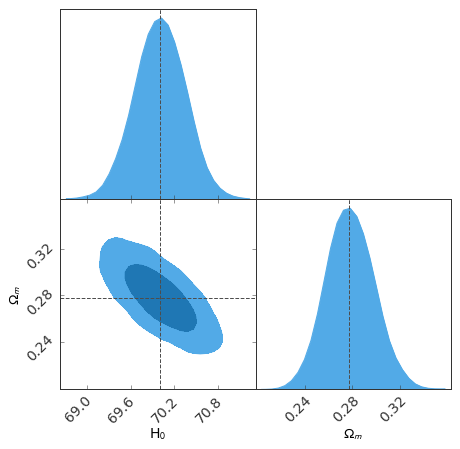

In [25]:
import pygtc
GTC = pygtc.plotGTC(chains=flat_samples,paramNames=labels,figureSize=7,holdRC=True,
                    customLabelFont={'size':14},customTickFont={'size':14}, truths=flat_samples[Max_likelihood,:])

# Lets see the result

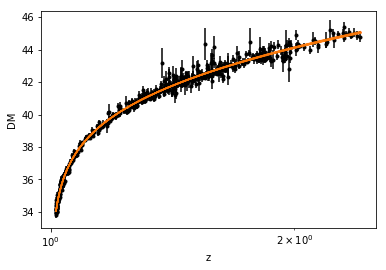

In [26]:
inds = np.random.randint(len(flat_samples), size=100)
x0 = np.sort(z)
plt.errorbar(1+z, DM, yerr=DM_err, fmt=".k", capsize=0)
for ind in inds:
    sample = flat_samples[ind]
    plt.plot(1+x0, distance_modulus(sample,x0),"C1", alpha=0.1,zorder=3)

#plt.plot(x0, distance_modulus(sample,x0),"C1", alpha=0.1)
plt.xlabel("z")
plt.ylabel("DM")
plt.xscale("log")

## Adding more parameters

Relax assumption on geometry of the Universe and fit for both $\Omega_M$ and $\Omega_\Lambda$

In [27]:
from astropy.cosmology import LambdaCDM

In [28]:
def distance_modulus(theta,z):
    H0, Om0, Ode0 = theta
    cosmo = LambdaCDM(H0=H0, Om0=Om0, Ode0=Ode0)
    distmod = np.array(cosmo.distmod(z))
    return distmod

def log_prior(theta):
    H0, Om0, Ode0 = theta
    if 0 < H0 < 150 and 0.0 < Om0 < 2.0 and 0.0 < Ode0 < 2.0:
        return 0.0
    return -np.inf

def log_likelihood():
#add code here
    return logl

def log_posterior():
#add code here
    return logpos

In [1]:
#Run chains

In [2]:
#Plot the result

## Changing priors:

Add a gaussian prior on $\Omega_M$ with mean $\mu = 0.27$ and $\sigma = 0.03$

In [36]:
def log_prior(theta):
    H0, Om0, Ode0 = theta
    
    Om0_mean = 0.27
    Om0_sigma = 0.03

    #Add code here

In [3]:
#Run chains and check results

## Curvature

Compare marginalized distribution on the Curvature of the Universe $\Omega_k = \Omega_M + \Omega_\Lambda$ for the above two chains (with and without gaussian prior)

## Changing the intrinsic scatter

Assume that not all the variation is captured by the measurement uncertainty, but the data points are also affected by an intrinsic constant scatter

In [4]:
def distance_modulus(theta,z):
    H0, Om0, Ode0, intrinsic_scatter = theta
    cosmo = LambdaCDM(H0=H0, Om0=Om0, Ode0=Ode0)
    distmod = np.array(cosmo.distmod(z))
    return distmod

def log_prior(theta):
    H0, Om0, Ode0, intrinsic_scatter = theta
    if 0 < H0 < 150 and 0.0 < Om0 < 2.0 and 0.0 < Ode0 < 2.0 and 0.<intrinsic_scatter<1.:
        return 0.0
    return -np.inf

#Add code here

In [5]:
#run chains and compare results

# Different Likelihood

We define the richness $\lambda$ of a galaxy cluster as the number of galaxies belonging to the cluster. 
Assume that the observed richness $\lambda_\mathrm{obs}$ is a Poisson realization of an instrinsic cluster properry $\lambda_\mathrm{true}$, which is linked to the cluster mass as:
\begin{equation}
ln \lambda_\mathrm{true} = A + B ln M
\end{equation}

Derive posterior distributions for A and B 

Step 1: Lets create the cluster sample. We randomly create a sample of Nclusters uniformly distributed in the range $10^{14}<M<10^{14}$. We then assigned lambda_true based on the input values. lambda_true is therefore the mean $\lambda_\mathrm{true}$ from which we will extract a Poisson realization $\lambda_\mathrm{obs}$ 

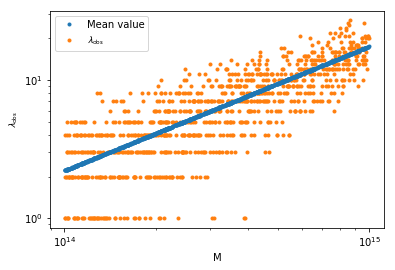

In [83]:
Nclusters = 1000
A_input = 9.4
B_input = 0.9
M = 10**(np.random.uniform(0,1,Nclusters)+14)
M_pivot = 5.e14
lambda_true = np.exp(np.log(A_input) + B_input*np.log(M/M_pivot))
lambda_obs = np.random.poisson(lambda_true)

plt.loglog(M,lambda_true,'.',label='Mean value', zorder=10)
plt.loglog(M,lambda_obs,'.',label="$\lambda_\mathrm{obs}$")
plt.xlabel("M")
plt.ylabel("$\lambda_\mathrm{obs}$")
plt.legend()

Lets define a log Poisson likelihooh which is proportional to $ln L = N_\mathrm{obs}  ln N_\mathrm{th} - N_\mathrm{th} - ln (N_\mathrm{obs}!)$

In [6]:
#Define Poisson likelihood and run chains to recover A and B

# What happens if you change M_pivot?